In [59]:
import math
from datetime import date, timedelta
from demeter.indicator.common import get_real_n
import pandas as pd

from demeter import TokenInfo, Actuator, Strategy, RowData, exponential_moving_average, simple_moving_average,  realized_volatility, ChainType, MarketInfo,PriceTrigger, CustomizedTrigger, PeriodTrigger, \
    BaseAction
from demeter.result import performance_metrics
from demeter.uniswap import UniV3Pool, UniLpMarket
from typing import List
from demeter.broker import AccountStatus
from matplotlib.pylab import plt
import matplotlib.dates as mdates
#Set matplotlib to show formatted account status
def plotter(account_status_list: List[AccountStatus]):
    net_value_ts = [status.net_value for status in account_status_list]
    time_ts = [status.timestamp for status in account_status_list]
    plt.plot(time_ts, net_value_ts)
    plt.show()

#Make plot about price and account value / position net value
def plot_position_return_decomposition(account_status: pd.DataFrame, price: pd.Series, market: MarketInfo):
    fig, value_ax = plt.subplots()
    day = mdates.DayLocator(interval=2)

    price_ax = value_ax.twinx()
    price_ax.xaxis.set_major_locator(day)
    price_ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    value_ax.set_xlabel('time')
    value_ax.set_ylabel('value', color='g')
    price_ax.set_ylabel('price', color='b')

    net_value_ts = list(account_status.net_value)
    time_ts = list(account_status.index)
    price_ts = list(price)

    value_in_position = account_status[market.name]["net_value"]
    value_in_account = account_status["tokens"]["USDC"] + account_status["tokens"]["ETH"] * price

    value_ax.plot(time_ts, net_value_ts, 'g-', label="net value")
    value_ax.plot(time_ts, value_in_position, 'r-', label="value in get_position")
    value_ax.plot(time_ts, value_in_account, 'b-', label="value in broker account")
    price_ax.plot(time_ts, price_ts, 'y-', label="price")
    fig.legend()
    fig.show()


ImportError: cannot import name 'CustomizedTrigger' from 'demeter' (/Users/gnapsamuel/Documents/AMM/demeter/demeter/__init__.py)

In [58]:
def volume_weighted_moving_average(
    data: pd.Series | pd.DataFrame,
    window: timedelta = timedelta(hours=5),
    min_periods: int | None = None,
    center: bool = False,
    win_type: str | None = None,
    on: str | None = None,
    closed: str | None = None,
    method: str = "single",
) -> pd.Series:
    """
    calculate volume weighted moving average

    docs for other params, see https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.rolling.html

    :param data: Pandas datarame
    :type data: Series
    :param window: window width
    :type window: timedelta
    :return: volume weighted moving average
    :rtype: Series

    """
    volume = abs(data["netAmount0"].astype(np.float64))
    price = data["price"].astype(np.float64)
    price_volume = volume * price
    rolling_price_volume = price_volume.rolling(
        window=get_real_n(price_volume, window),
        min_periods=min_periods,
        center=center,
        win_type=win_type,
        on=on,
        closed=closed,
        method=method,
    ).sum()
    rolling_volume = volume.rolling(
        window=get_real_n(volume, window),
        min_periods=min_periods,
        center=center,
        win_type=win_type,
        on=on,
        closed=closed,
        method=method,
    ).sum()
    return rolling_price_volume / rolling_volume

In [53]:
c = 2
class AddByVolatilityStrategy(Strategy):

    def initialize(self):
        """
        This function is called before main loop is executed.
        you can prepare data, or register trigger here
        """
        # 1-day timeframe (existing)
        self.add_column(market_key, "sma_1_day", simple_moving_average(self.data[market_key].price, timedelta(days=1)))
        self.add_column(market_key, "ema_1_day", exponential_moving_average(self.data[market_key].price, com=0.8))
        self.add_column(
            market_key,
            "volatility_1_day",
            realized_volatility(self.data[market_key].price, timedelta(days=1), timedelta(days=1)),
        )

        # 5-minute timeframe
        self.add_column(market_key, "sma_5_min", simple_moving_average(self.data[market_key].price, timedelta(minutes=5)))
        self.add_column(
            market_key,
            "volatility_5_min",
            realized_volatility(self.data[market_key].price, timedelta(minutes=5), timedelta(minutes=5)),
        )

        # 15-minute timeframe
        self.add_column(market_key, "sma_15_min", simple_moving_average(self.data[market_key].price, timedelta(minutes=15)))
        self.add_column(
            market_key,
            "volatility_15_min",
            realized_volatility(self.data[market_key].price, timedelta(minutes=15), timedelta(minutes=15)),
        )

        # 1-hour timeframe
        self.add_column(market_key, "sma_1_hour", simple_moving_average(self.data[market_key].price, timedelta(hours=1)))
        self.add_column(
            market_key,
            "volatility_1_hour",
            realized_volatility(self.data[market_key].price, timedelta(hours=1), timedelta(hours=1)),
        )

        # 4-hour timeframe
        self.add_column(market_key, "sma_4_hour", simple_moving_average(self.data[market_key].price, timedelta(hours=4)))
        self.add_column(
            market_key,
            "volatility_4_hour",
            realized_volatility(self.data[market_key].price, timedelta(hours=4), timedelta(hours=4)),
        )
        self.triggers.append(PeriodTrigger(time_delta=timedelta(hours=16), trigger_immediately=True, do=self.work))
        self.triggers.PriceTrigger(
            condition=lambda p: p["eth"] > 1714.35, do=self.work)
        
        self.markets.default.even_rebalance(self.data[market_key].iloc[0]["price"])
    
    def work(self, row_data: RowData):
        lp_market: UniLpMarket = self.broker.markets[market_key]
        lp_row_data = row_data.market_status[market_key]
        if len(lp_market.positions) > 0:
            lp_market.remove_all_liquidity()
            lp_market.even_rebalance(row_data.prices[eth.name])
        if math.isnan(lp_row_data.volatility_1_day):
            return
        limit = c * float(row_data.prices[eth.name]) * lp_row_data.volatility_1_day
        if self.broker.assets[market.base_token].balance > 0:
            lp_market.add_liquidity(lp_row_data.ema_1_day - limit, lp_row_data.ema_1_day+limit*.5)
        else:
            lp_market.add_liquidity(lp_row_data.ema_1_day - limit*.5, lp_row_data.ema_1_day + limit)

In [ ]:

c = 2
class AddByVolatilityStrategy(Strategy):
    def handle_out_of_range(self, row_data: RowData):
        self.work(row_data)

    def __init__(self):
        super().__init__()
        self.lower_range = None
        self.upper_range = None

    def initialize(self):
        """
        This function is called before main loop is executed.
        you can prepare data, or register trigger here
        """
        # 1-day timeframe (existing)
        self.add_column(market_key, "sma_1_day", simple_moving_average(self.data[market_key].price, timedelta(days=1)))
        self.add_column(market_key, "ema_1_day", exponential_moving_average(self.data[market_key].price, com=0.8))
        self.add_column(
            market_key,
            "volatility_1_day",
            realized_volatility(self.data[market_key].price, timedelta(days=1), timedelta(days=1)),
        )

        # 5-minute timeframe
        self.add_column(market_key, "sma_5_min", simple_moving_average(self.data[market_key].price, timedelta(minutes=5)))
        self.add_column(
            market_key,
            "volatility_5_min",
            realized_volatility(self.data[market_key].price, timedelta(minutes=5), timedelta(minutes=5)),
        )

        # 15-minute timeframe
        self.add_column(market_key, "sma_15_min", simple_moving_average(self.data[market_key].price, timedelta(minutes=15)))
        self.add_column(
            market_key,
            "volatility_15_min",
            realized_volatility(self.data[market_key].price, timedelta(minutes=15), timedelta(minutes=15)),
        )

        # 1-hour timeframe
        self.add_column(market_key, "sma_1_hour", simple_moving_average(self.data[market_key].price, timedelta(hours=1)))
        self.add_column(
            market_key,
            "volatility_1_hour",
            realized_volatility(self.data[market_key].price, timedelta(hours=1), timedelta(hours=1)),
        )

        # 4-hour timeframe
        self.add_column(market_key, "sma_4_hour", simple_moving_average(self.data[market_key].price, timedelta(hours=4)))
        self.add_column(
            market_key,
            "volatility_4_hour",
            realized_volatility(self.data[market_key].price, timedelta(hours=4), timedelta(hours=4)),
        )
        def price_out_of_range(row_data: RowData):
            if self.lower_range is None or self.upper_range is None:
                return False
            current_price = row_data.prices[eth.name]
            return current_price < self.lower_range or current_price > self.upper_range

        self.triggers.append(CustomizedTrigger(condition=price_out_of_range, do=self.handle_out_of_range))

        # self.triggers.append(PeriodTrigger(time_delta=timedelta(hours=16), trigger_immediately=True, do=self.work))
        # self.triggers.PriceTrigger(
        #     condition=lambda p: p["eth"] > 1714.35, do=self.work)
        
        self.markets.default.even_rebalance(self.data[market_key].iloc[0]["price"])
    
    def work(self, row_data: RowData):
        lp_market: UniLpMarket = self.broker.markets[market_key]
        lp_row_data = row_data.market_status[market_key]
        if len(lp_market.positions) > 0:
            lp_market.remove_all_liquidity()
            lp_market.even_rebalance(row_data.prices[eth.name])
        if math.isnan(lp_row_data.volatility_1_day):
            return
        limit = c * float(row_data.prices[eth.name]) * lp_row_data.volatility_1_day
        if self.broker.assets[market.base_token].balance > 0:
            lp_market.add_liquidity(lp_row_data.ema_1_day - limit, lp_row_data.ema_1_day+limit*.5)
        else:
            lp_market.add_liquidity(lp_row_data.ema_1_day - limit*.5, lp_row_data.ema_1_day + limit)

In [54]:
usdc = TokenInfo(name="usdc", decimal=6)  # declare  token0
eth = TokenInfo(name="eth", decimal=18)  # declare token1
pool = UniV3Pool(usdc, eth, 0.05, usdc)  # declare pool
market_key = MarketInfo("uniswap_eth_udsc")

actuator = Actuator()  # declare actuator
broker = actuator.broker
market = UniLpMarket(market_key, pool)

broker.add_market(market)
broker.set_balance(usdc, 2000)
broker.set_balance(eth, 0)

actuator.strategy = AddByVolatilityStrategy()

market.data_path = "/Users/gnapsamuel/Documents/AMM/demeter-fetch/sample-data"
market.load_data(ChainType.ethereum.name, "0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640", date(2024, 7, 2),
                date(2024, 8, 1))
actuator.set_price(market.get_price_from_data())
actuator.run()

2024-10-07 22:08:04,455 - INFO - start load files from 2024-07-02 to 2024-08-01...
2024-10-07 22:08:04,598 - INFO - load file complete, preparing...
2024-10-07 22:08:05,103 - INFO - data has been prepared
2024-10-07 22:08:05,124 - INFO - Qute token is USDC
2024-10-07 22:08:05,124 - INFO - init strategy...
2024-10-07 22:08:07,016 - INFO - start main loop...
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 44640/44640 [00:05<00:00, 8877.28it/s]
2024-10-07 22:08:12,047 - INFO - main loop finished
2024-10-07 22:08:12,482 - INFO - Print actuator summary
2024-10-07 22:08:12,586 - INFO - Backtesting finished, execute time 7.462908029556274s


Final account status                              
Token balance in broker       
USDC      :0                        ETH       :0.14091565               
Position value in markets     
uniswap_eth_udsc(UniLpMarket)
token0    :USDC                     token1    :ETH                      fee(%)    :0.0500                   quote token:USDC                     
positions 
   lower_tick  upper_tick   pending0       pending1        liquidity
0      195700      196260  2.6149289  0.00076955383  866622945215835

Quote by: USDC
Account balance history                           
l1                  net_value    tokens            uniswap_eth_udsc  \
l2                                 USDC        ETH        net_value   
2024-07-02 00:00:00 1999.4999 999.74981 0.29057598                0   
2024-07-02 00:01:00 1999.4999 999.74981 0.29057598                0   
2024-07-02 00:02:00 1999.0001 999.74981 0.29057598                0   
2024-07-02 00:03:00 1999.0001 999.74981 0.29057598                0

In [56]:
print({k: v for k, v in performance_metrics(
    actuator.account_status_df["net_value"], benchmark=actuator.account_status_df["price"]["ETH"]
).items()})


{Start period: Timestamp('2024-07-02 00:00:00'), End period: Timestamp('2024-08-01 23:59:00'), Duration: Timedelta('31 days 00:00:00'), Return: -195.5467599022354, Rate of Return: -0.09779783552695032, APR: -0.7023272690371485, Max Draw Down: 0.15549745594728445, Sharpe Ratio: -1.9693375136320428, Volatility: 0.37186478395292805, Alpha: -0.3371831542303592, Beta: 0.6410778713794496, Benchmark return rate: -0.06909348496087198, Benchmark APR: -0.5695784102187615}


In [45]:
df = actuator.strategy.data[market_key]

In [46]:
df.columns

Index(['netAmount0', 'netAmount1', 'closeTick', 'openTick', 'lowestTick',
       'highestTick', 'inAmount0', 'inAmount1', 'currentLiquidity', 'open',
       'price', 'low', 'high', 'volume0', 'volume1', 'sma_1_day', 'ema_1_day',
       'volatility_1_day', 'sma_5_min', 'volatility_5_min', 'sma_15_min',
       'volatility_15_min', 'sma_1_hour', 'volatility_1_hour', 'sma_4_hour',
       'volatility_4_hour'],
      dtype='object')

In [47]:
df[['price','sma_1_day','sma_15_min',
       'volatility_1_day', 'sma_5_min', 'volatility_5_min', 'sma_15_min',
       'volatility_15_min', 'sma_1_hour', 'volatility_1_hour', 'sma_4_hour',
       'volatility_4_hour']]

,price,sma_1_day,sma_15_min,volatility_1_day,sma_5_min,volatility_5_min,sma_15_min,volatility_15_min,sma_1_hour,volatility_1_hour,sma_4_hour,volatility_4_hour
2024-07-02 00:00:00,3440.5804822488603066103299858708544,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-07-02 00:01:00,3440.5804822488603066103299858708544,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-07-02 00:02:00,3438.8607079744119766363274444637814,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-07-02 00:03:00,3438.8607079744119766363274444637814,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-07-02 00:04:00,3438.8607079744119766363274444637814,NaN,NaN,NaN,3439.548618,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-01 23:55:00,3202.8587864419291118006138564495336,3167.769000,3205.016585,0.016200,3202.858793,0.000336,3205.016585,0.001091,3204.958808,0.004388,3175.717442,0.009993
2024-08-01 23:56:00,3202.8587864419291118006138564495336,3167.748893,3204.738837,0.016206,3202.794736,0.000336,3204.738837,0.001251,3204.926771,0.004327,3176.031294,0.009907
2024-08-01 23:57:00,3202.8587864419291118006138564495336,3167.728561,3204.461089,0.016212,3202.858786,0.000349,3204.461089,0.001372,3204.873366,0.004253,3176.332108,0.009821
2024-08-01 23:58:00,3202.8587864419291118006138564495336,3167.708230,3204.097808,0.016218,3202.858786,0.000270,3204.097808,0.001469,3204.819961,0.004159,3176.632922,0.009741


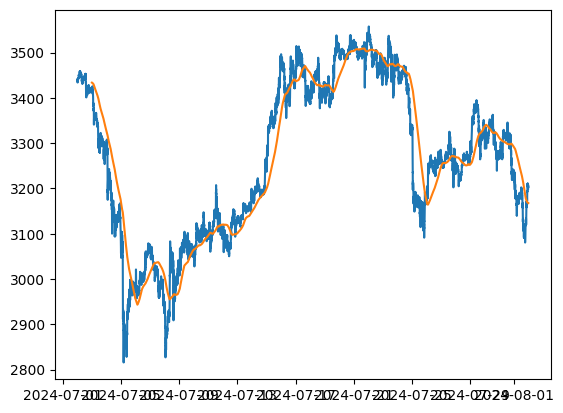

In [48]:
plt.plot(df[['ema_1_day','sma_1_day']])

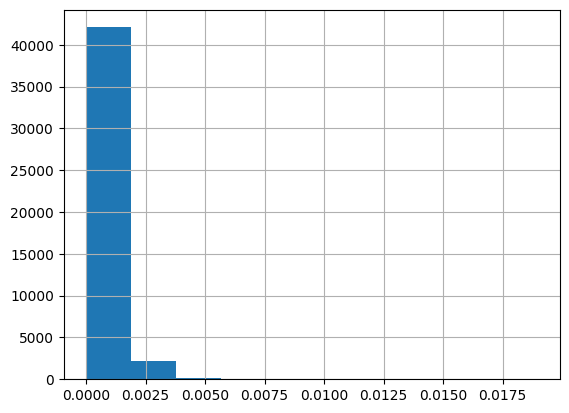

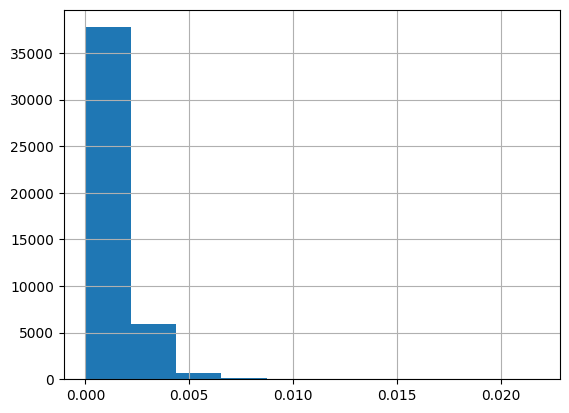

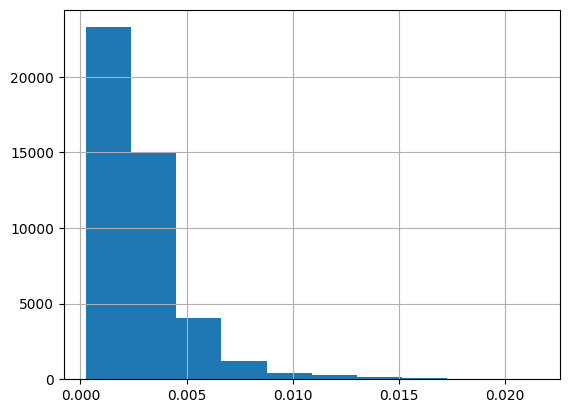

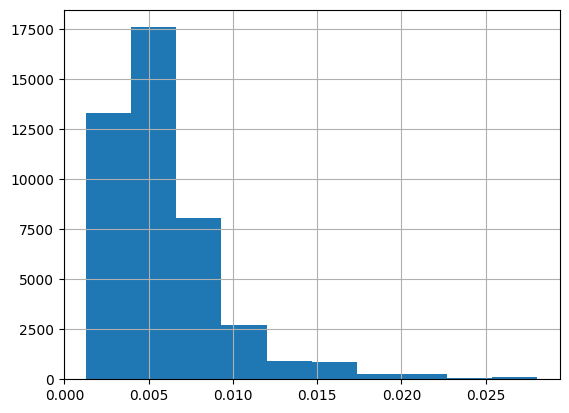

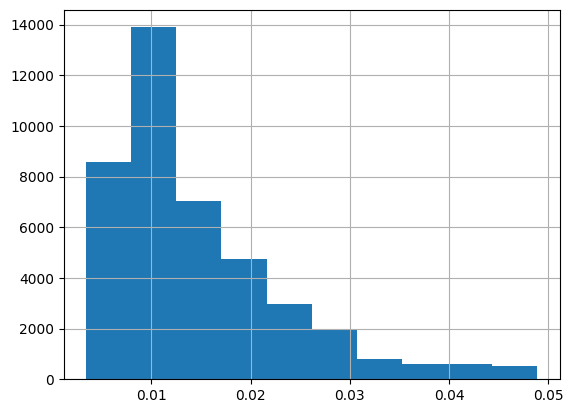

In [36]:
for i in ['volatility_5_min','volatility_15_min',
        'volatility_1_hour','volatility_4_hour', 'volatility_1_day',  ]:
    df[i].hist()
    plt.show()

<Axes: >

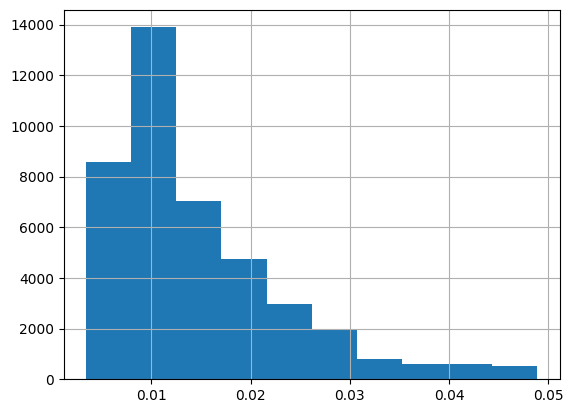

In [24]:
df['volatility'].hist()

What about using a dollar bar or volume bar instead of a minute data? We could use Intrinsic Entropy Model to estiamte volatilty?

In [ ]:

def plot_data():
    # Create the figure and axes
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot price, sma_1h, and sma_6h on the primary y-axis
    ax1.plot(df.index, df['price'], label='Price', color='blue')
    ax1.plot(df.index, df['kama'], label='kama', color='green')
    ax1.plot(df.index, df['sma_6h'], label='SMA 6h', color='red')

    # Set up the primary y-axis
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price / SMA')
    ax1.tick_params(axis='y')

    # Create a secondary y-axis for volatility
    ax2 = ax1.twinx()
    ax2.plot(df.index, df['volatility_12h'], label='volatility_12h', color='purple', alpha=0.5)
    ax2.plot(df.index, df['volatility_1d'], label='volatility_1d', color='y', alpha=0.5)
    ax2.set_ylabel('Volatility')
    ax2.tick_params(axis='y')

    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    # Format the date on the x-axis
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    plt.gcf().autofmt_xdate()  # Rotate and align the tick labels

    plt.title('Price, SMAs, and Volatility Over Time')
    plt.tight_layout()
    plt.show()

In [ ]:
from demeter import realized_volatility

In [ ]:
df = actuator.strategy.data[market_key]

In [ ]:
df['volume1'].max()

Decimal('3936.978121020261951254')

In [ ]:
df['kama'] = df['kama'].replace(0, np.nan)

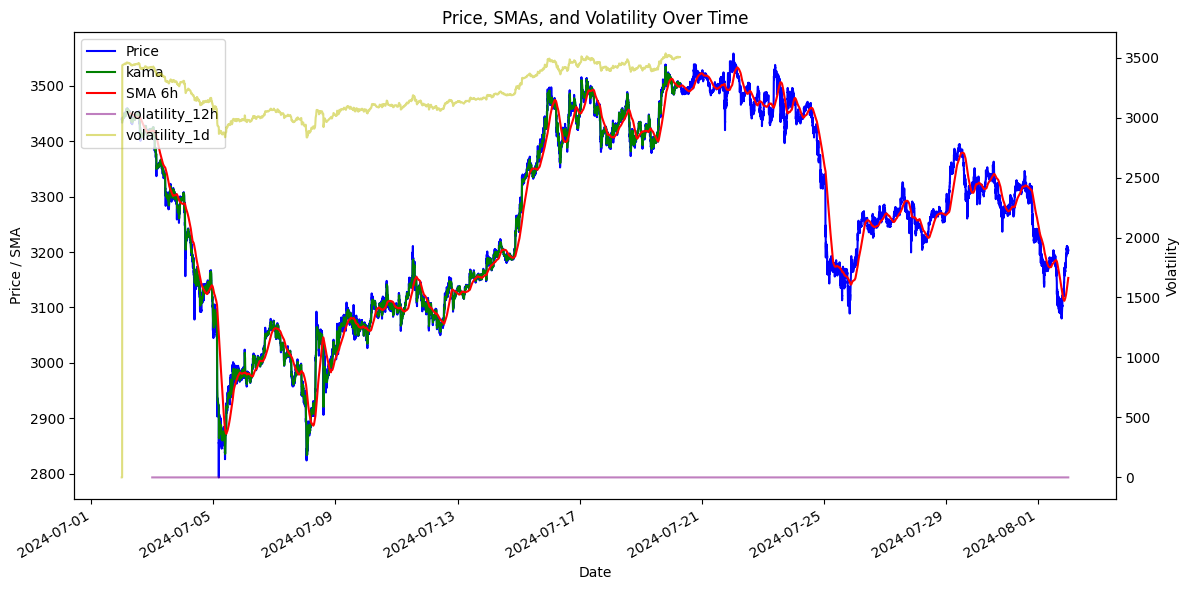

In [ ]:
plot_data()

In [ ]:
def prepare_har_data(returns, lookback_daily=1, lookback_weekly=5, lookback_monthly=22):
    """Prepare data for HAR model"""
    rv_daily = returns.rolling(window=lookback_daily*1440).apply(lambda x: calculate_realized_volatility(x, 1))
    rv_weekly = returns.rolling(window=lookback_weekly*1440).apply(lambda x: calculate_realized_volatility(x, 5))
    rv_monthly = returns.rolling(window=lookback_monthly*1440).apply(lambda x: calculate_realized_volatility(x, 22))
    
    har_data = pd.concat([rv_daily, rv_weekly, rv_monthly], axis=1)
    har_data.columns = ['RV_d', 'RV_w', 'RV_m']
    har_data['RV_next'] = rv_daily.shift(-1)
    
    return har_data.dropna()

def fit_har_model(har_data):
    """Fit HAR model"""
    X = har_data[['RV_d', 'RV_w', 'RV_m']]
    y = har_data['RV_next']
    model = LinearRegression()
    model.fit(X, y)
    return model